In [1]:
from functools import partial
import pickle

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.special import factorial, hermitenorm

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
import jaxopt

from schnecke.model import VerticalOrbitModel
from schnecke.data import get_data_im

In [3]:
# self.e8_knots = jnp.array(e8_knots)

In [36]:
model = VerticalOrbitModel(
    dens_knots=jnp.linspace(0, np.sqrt(1.5), 9)**2,
    e2_knots=jnp.linspace(0, np.sqrt(1.2), 15)**2,
    e4_knots=jnp.linspace(0, np.sqrt(1.2), 15)**2
)

In [38]:
Omegaz0 = ((15*u.km/u.s) / (450*u.pc)).to_value(1/u.Myr)

In [39]:
im_bins = {'z': np.linspace(-4, 4, 121)}
im_bins['vz'] = im_bins['z'] * Omegaz0

In [40]:
test_data = at.QTable.read("GaiaDR3-zvz-Rg8.0-9.0.fits")
# test_data = at.QTable.read("GaiaDR3-zvz-Rg10.0-11.0.fits")

# Simulated data to try here in test_data
# rng = np.random.default_rng(seed=42)
# test_data['z'] = rng.normal(
#     0, 1.5 * MAD(test_data['z'].value), size=len(test_data)
# ) * test_data['z'].unit
# test_data['vz'] = rng.normal(
#     0, 1.5 * MAD(test_data['vz'].value), size=len(test_data)
# ) * test_data['vz'].unit

data_H = get_data_im(test_data['z'], test_data['vz'], im_bins)
# data_H = get_data_im(test_data['z'][:len(test_data)//2], test_data['vz'][:len(test_data)//2], im_bins)

In [41]:
e2_0 = np.zeros(len(model.e2_knots))
e2_0[4] = 0.2
e4_0 = np.zeros(len(model.e4_knots))
e4_0[4] = -0.1

params0 = {
    'vz0': 0.,
    'z0': 0.,
    'ln_dens_vals': np.array([11.,  6.,  2., -2, -5] + [-5.] * (len(model.dens_knots) - 5)),
    'ln_Omega': np.log(Omegaz0 / 1.5),
    'e2_vals': e2_0,
    'e4_vals': e4_0
#     'e2_vals': np.full(len(model.e2_knots), 0.2),
#     'e4_vals': -np.full(len(model.e4_knots), 0.1)
}

bounds_l = {
    'vz0': -0.1,
    'z0': -0.5,
    'ln_dens_vals': np.full_like(params0['ln_dens_vals'], -5.),
    'ln_Omega': -5.,
    'e2_vals': np.full_like(params0['e2_vals'], 0.),
    'e4_vals': np.full_like(params0['e4_vals'], -0.3)
#     'e2_vals': np.full_like(params0['e2_vals'], -0.2),
#     'e4_vals': np.full_like(params0['e4_vals'], -0.1)
}

bounds_r = {
    'vz0': 0.1,
    'z0': 0.5,
    'ln_dens_vals': np.full_like(params0['ln_dens_vals'], 15.),
    'ln_Omega': 0.,
    'e2_vals': np.full_like(params0['e2_vals'], 0.3),
#     'e4_vals': np.full_like(params0['e4_vals'], 0.1)
    'e4_vals': np.full_like(params0['e4_vals'], 0.)
}

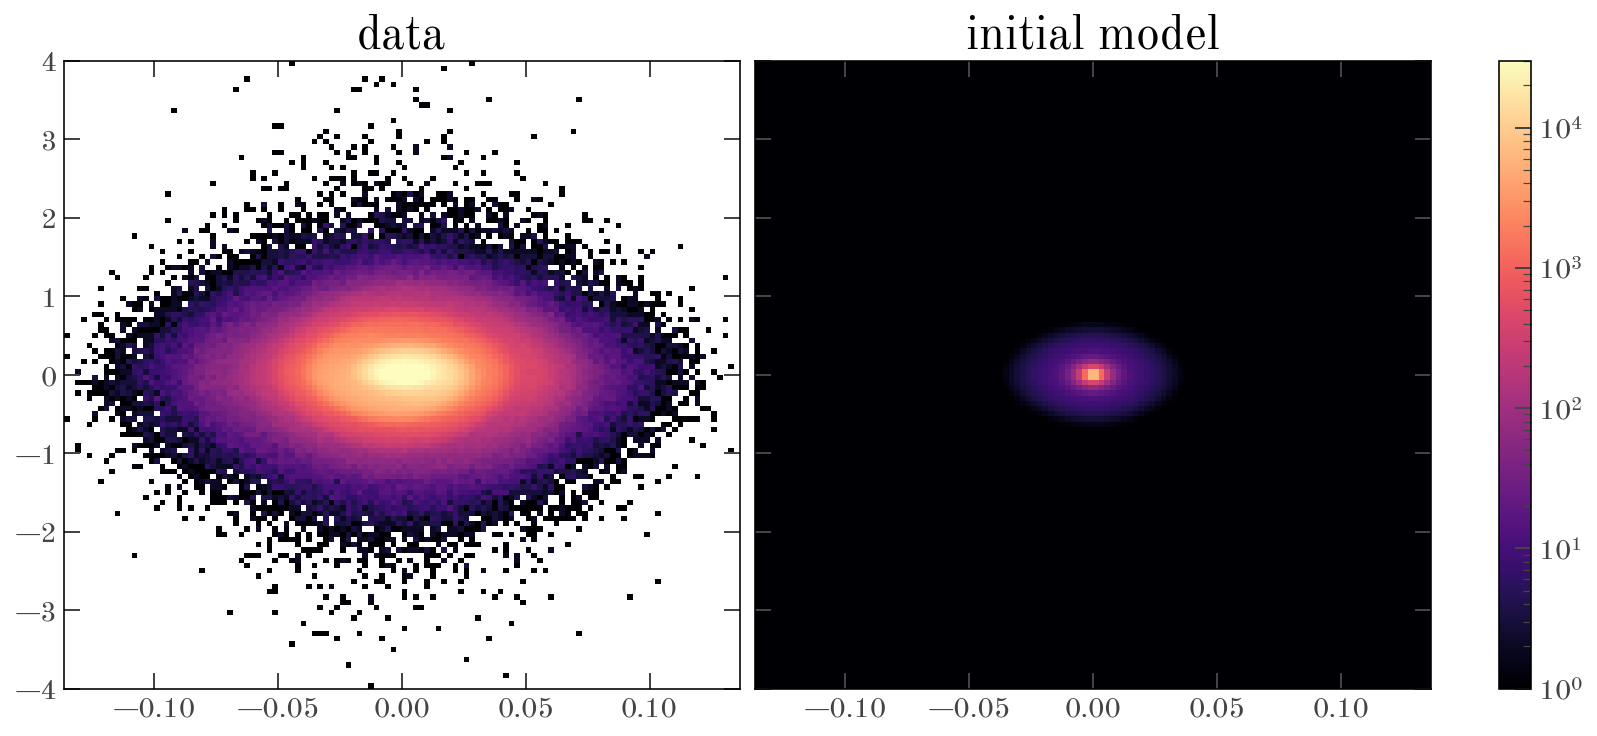

In [42]:
vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4)) # vmin=0, vmax=30)

fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), sharex=True, sharey=True, 
    constrained_layout=True
)

cs = axes[0].pcolormesh(data_H['vz'], data_H['z'], data_H['H'], **vlim)

cs = axes[1].pcolormesh(
    data_H['vz'], data_H['z'], 
    np.exp(model.ln_density(params0, z=data_H['z'], vz=data_H['vz']).T), 
    **vlim
)
fig.colorbar(cs, ax=axes[:2])

axes[0].set_title('data')
axes[1].set_title('initial model');

In [43]:
_, init_rz, _ = model.get_rz_th(
    data_H['z'].ravel()[:10], data_H['vz'].ravel()[:10], 
    np.exp(params0['ln_Omega']), params0['e2_vals'], params0['e4_vals']
)
de2_de24, de4_de24 = jax.jacrev(model.get_e2_e4, argnums=[1, 2])(
    init_rz, params0['e2_vals'], params0['e4_vals']
)
# jax.jacrev(pchip_interpolate_uniform, argnums=[1])(model.e2_knots, params0['e2_vals'], init_rz)
np.isfinite(de2_de24[0]).all(), np.isfinite(de4_de24[1]).all()

(True, True)

In [44]:
# jax.grad(model.objective)(bounds_r, **data_H)

In [45]:
res = model.optimize(
    params0, bounds=(bounds_l, bounds_r), **data_H, 
    jaxopt_kwargs=dict(options=dict(maxls=1000, disp=False))
)
res.state

ScipyMinimizeInfo(fun_val=Array(5.15318705, dtype=float64, weak_type=True), success=True, status=0, iter_num=1173)

In [46]:
res.params

{'e2_vals': Array([0.        , 0.        , 0.        , 0.        , 0.22853613,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],      dtype=float64),
 'e4_vals': Array([-0.03442759, -0.03445798, -0.03110527, -0.00230893, -0.00677953,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],      dtype=float64),
 'ln_Omega': Array(-2.6462342, dtype=float64),
 'ln_dens_vals': Array([11.09227713, 10.57026411,  8.77013668,  5.86993543,  1.97831254,
        -2.02141818, -5.        , -4.92312153, -5.        ], dtype=float64),
 'vz0': Array(0.00124165, dtype=float64),
 'z0': Array(0.01108879, dtype=float64)}

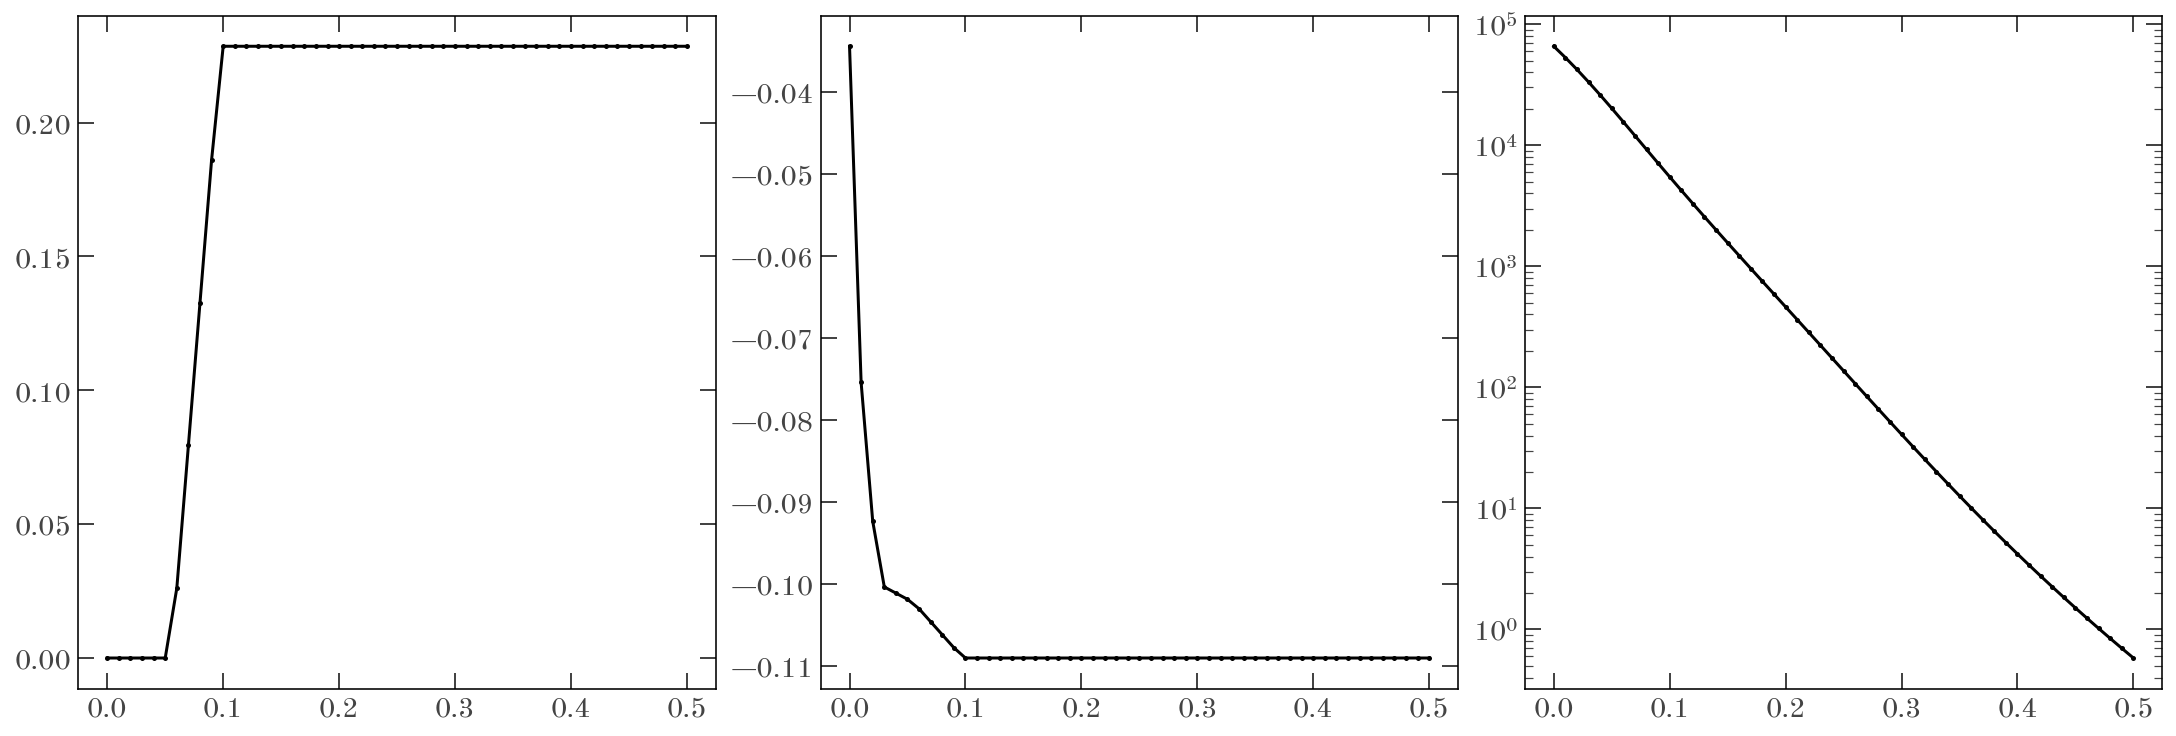

In [50]:
plot_rz = np.linspace(0, 0.5, 51)
e2s, e4s = model.get_e2_e4(plot_rz, res.params['e2_vals'], res.params['e4_vals'])
dens = np.exp(model.get_ln_dens(plot_rz, res.params['ln_dens_vals']))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes[0].plot(plot_rz, e2s)
axes[1].plot(plot_rz, e4s)
axes[2].plot(plot_rz, dens)
axes[2].set_yscale('log')

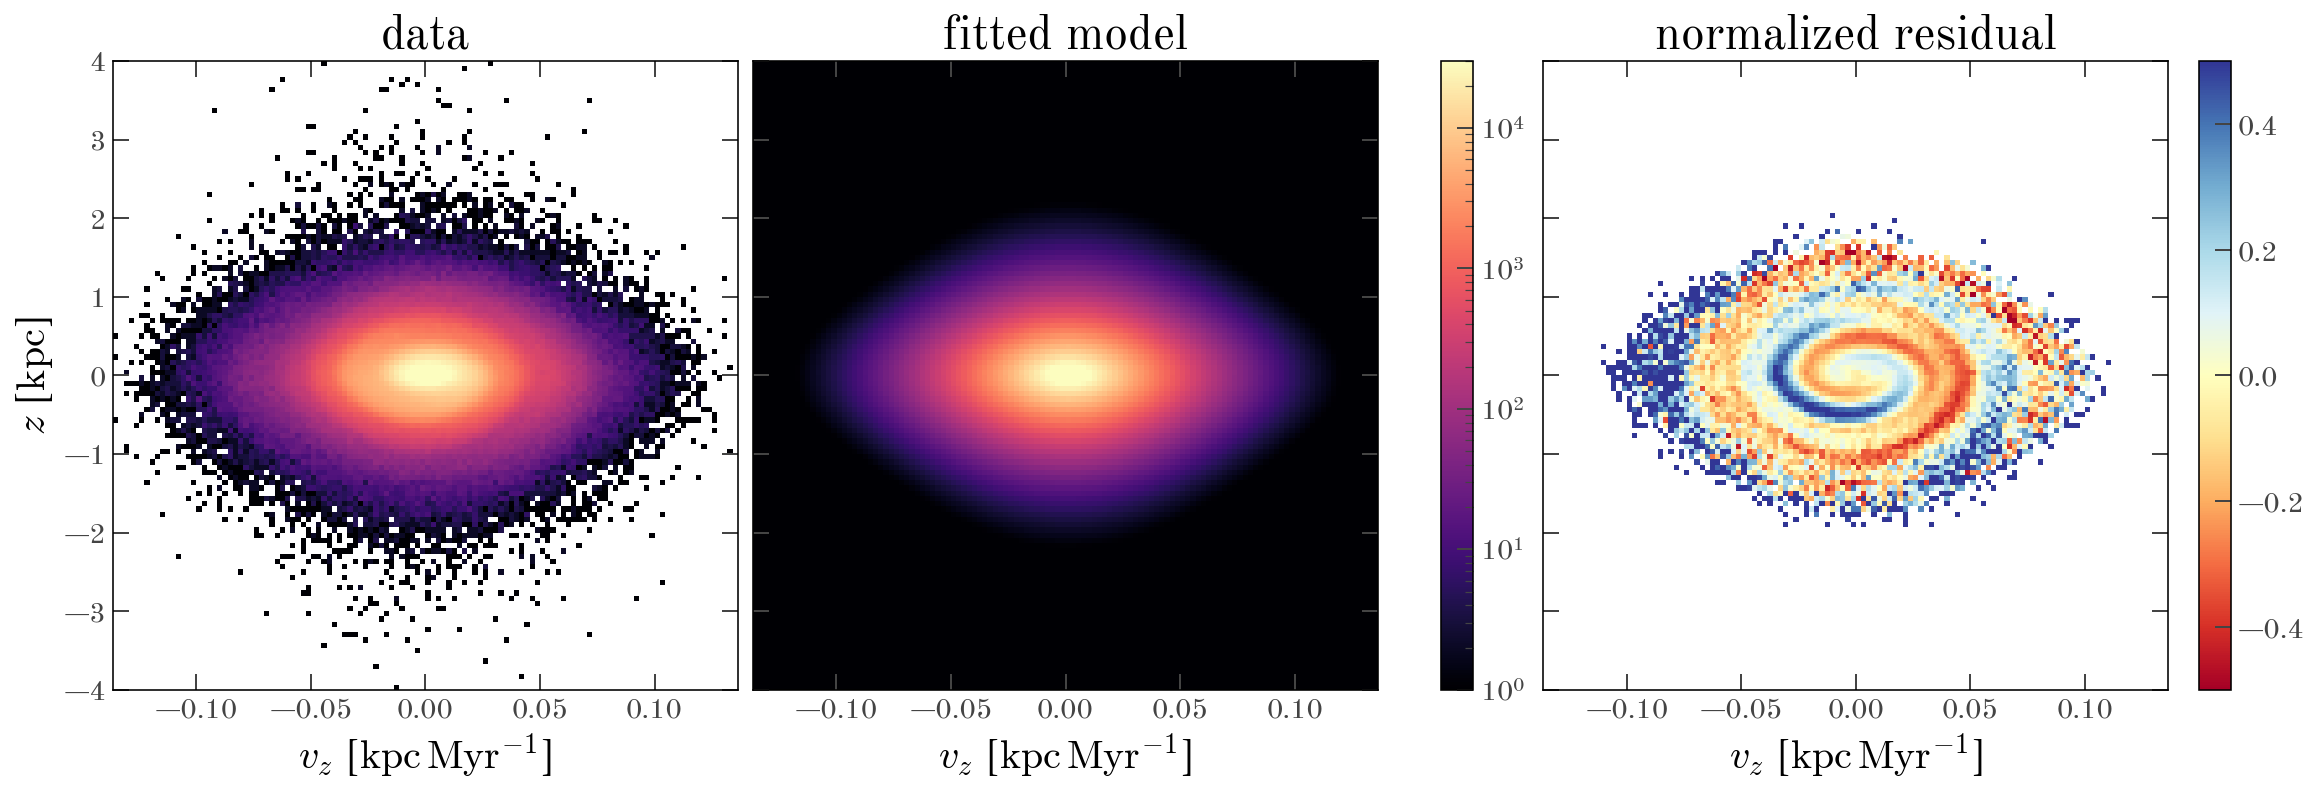

In [51]:
vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4))

fig, axes = plt.subplots(
    1, 3, figsize=(16, 5.4), sharex=True, sharey=True, 
    constrained_layout=True
)

cs = axes[0].pcolormesh(data_H['vz'], data_H['z'], data_H['H'], **vlim)

model_H = np.exp(model.ln_density(res.params, z=data_H['z'], vz=data_H['vz']))
cs = axes[1].pcolormesh(data_H['vz'], data_H['z'], model_H, **vlim)
fig.colorbar(cs, ax=axes[:2])

resid = np.array((data_H['H'] - model_H) / model_H)
resid[data_H['H'] < 5] = np.nan
# resid = convolve(resid, Gaussian2DKernel(0.65))
cs = axes[2].pcolormesh(
    data_H['vz'], data_H['z'], 
    resid, 
    vmin=-0.5, vmax=0.5,
    cmap='RdYlBu'
)
fig.colorbar(cs, ax=axes[2])

for ax in axes:
    ax.set_xlabel(f'$v_z$ [{u.kpc/u.Myr:latex_inline}]')
axes[0].set_ylabel(f'$z$ [{u.kpc:latex_inline}]')

axes[0].set_title('data')
axes[1].set_title('fitted model')
axes[2].set_title('normalized residual');

In [52]:
rz, init_rz, init_th = model.get_rz_th(
    test_data['z'].to_value(u.kpc), 
    test_data['vz'].to_value(u.kpc/u.Myr), 
    np.exp(res.params['ln_Omega']), 
    res.params['e2_vals'], 
    res.params['e4_vals']
)

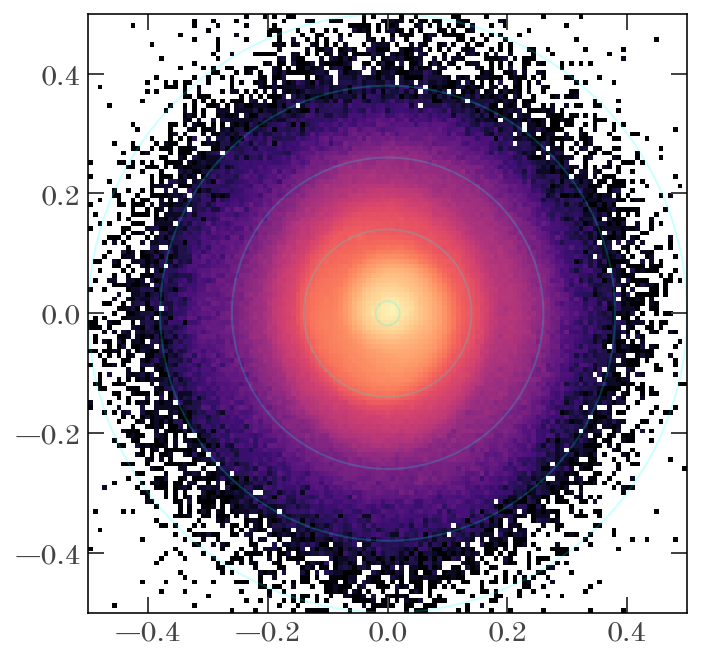

In [53]:
xx = rz * np.cos(init_th)
yy = rz * np.sin(init_th)

fig, ax = plt.subplots(1, 1, figsize=(5.4, 5.4))
cs = ax.hist2d(xx, yy, bins=np.linspace(-0.5, 0.5, 128), **vlim)
ax.set_aspect('equal')

for rr in np.linspace(0.02, 0.5, 5):
    circ = mpl.patches.Circle((0,0), rr, facecolor='none', edgecolor='cyan', alpha=0.2)
    ax.add_patch(circ)

(-6.283185307179586, 6.283185307179586)

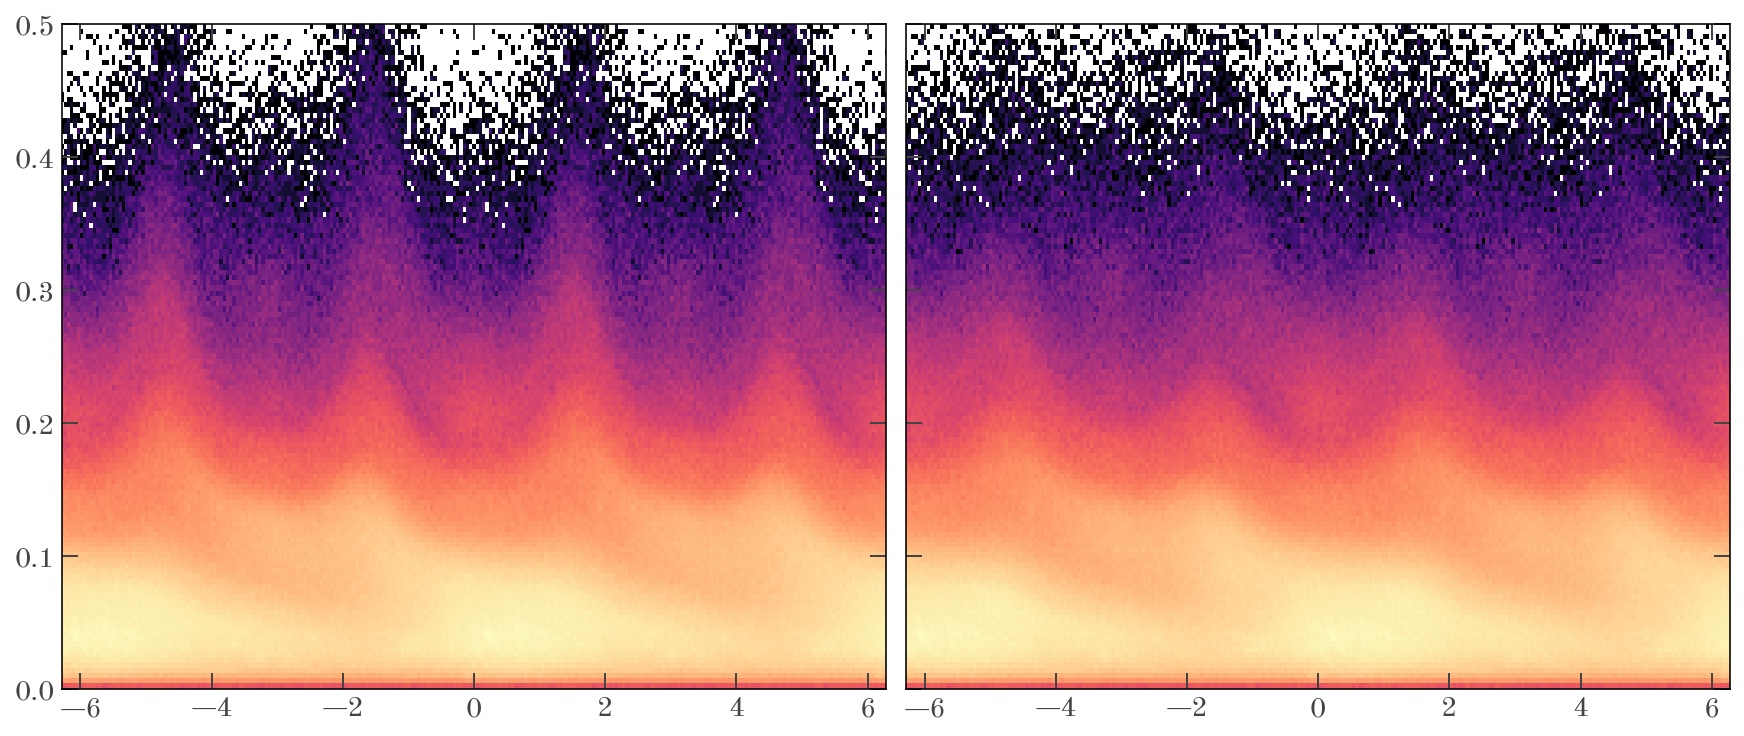

In [54]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True,
    constrained_layout=True
)

for n in [-1, 0, 1]:
    axes[0].hist2d(
        init_th + n * 2*np.pi, 
        init_rz, 
        bins=(np.linspace(-np.pi, np.pi, 128) + n * 2*np.pi, 
              np.linspace(0, 0.5, 128)), 
        norm=mpl.colors.LogNorm()
    )
    
    axes[1].hist2d(
        init_th + n * 2*np.pi, 
        rz, 
        bins=(np.linspace(-np.pi, np.pi, 128) + n * 2*np.pi, 
              np.linspace(0, 0.5, 128)), 
        norm=mpl.colors.LogNorm()
    )
    
axes[0].set_xlim(-2*np.pi, 2*np.pi)

(-6.283185307179586, 6.283185307179586)

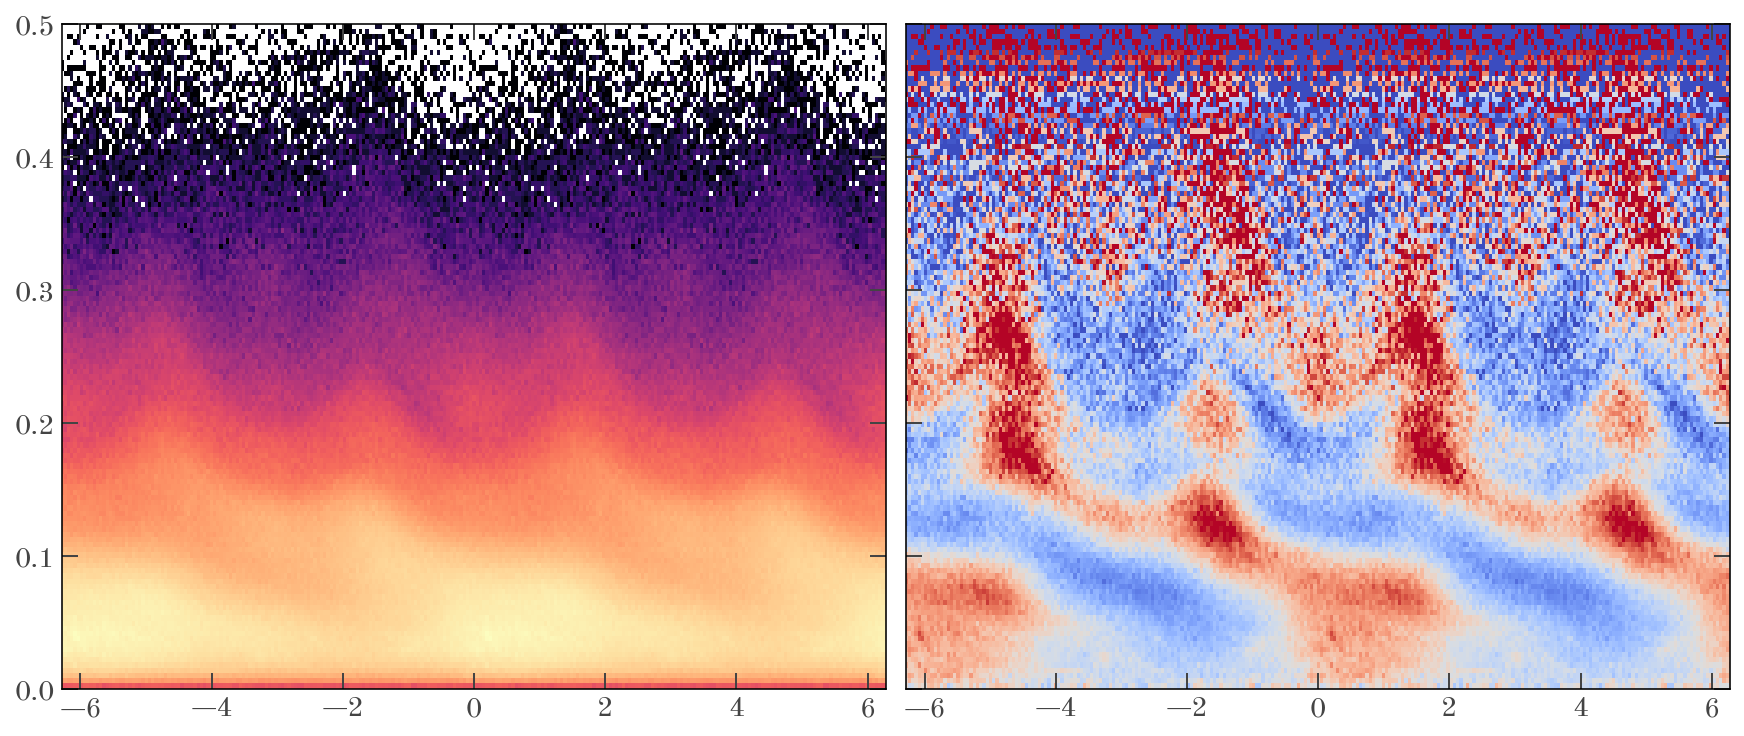

In [55]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True,
    constrained_layout=True
)

for n in [-1, 0, 1]:
    H, xe, ye = np.histogram2d(
        init_th + n * 2*np.pi, 
        rz, 
        bins=(np.linspace(-np.pi, np.pi, 128) + n * 2*np.pi, 
              np.linspace(0, 0.5, 128))
    )
    
    axes[0].pcolormesh(
        xe, ye, H.T,
        norm=mpl.colors.LogNorm()
    )
    
#     rz_grid, th_grid = np.meshgrid(
#         0.5 * (ye[:-1] + ye[1:]), 
#         0.5 * (xe[:-1] + xe[1:])
#     )
#     zz = rz_grid * np.sin(th_grid) / np.exp(0.5 * res.params['ln_Omega'])
#     vzz = rz_grid * np.cos(th_grid) * np.exp(0.5 * res.params['ln_Omega'])
#     model_H = np.exp(model.ln_density(res.params, z=zz, vz=vzz))
    model_H = np.nanmean(H.T, axis=1)[:, None]
    axes[1].pcolormesh(
        xe, ye, (H.T - model_H) / model_H,
        vmin=-0.5, vmax=0.5,
        cmap='coolwarm'
    )
    
axes[0].set_xlim(-2*np.pi, 2*np.pi)

---

# Matched filter

In [167]:
import optax
from jax.scipy.special import logsumexp, gammaln

@jax.jit
def mixture_ln_likelihood(params, z, vz, H, dH, model_kwargs):
    model = VerticalOrbitModel(**model_kwargs)

    dH_sign = jnp.sign(dH)
    
    # Expected number:
    ln_Lambda = logsumexp(
        jnp.array([model.ln_density(params, z, vz), params['log_alpha'] + jnp.log(jnp.abs(dH))]),
        b=jnp.array([jnp.ones_like(H), dH_sign]),
        axis=0
    )
    ln_Lambda = jnp.where(
        jnp.isfinite(ln_Lambda),
        ln_Lambda,
        -6.
    )
    # ln_Lambda = model.ln_density(params, z, vz)

    # gammaln(x+1) = log(factorial(x))
    return H * ln_Lambda - jnp.exp(ln_Lambda) - gammaln(H + 1)


@jax.jit
def mixture_objective(params, z, vz, H, dH, model_kwargs):
    return -mixture_ln_likelihood(params, z, vz, H, dH, model_kwargs).sum() / H.size


def get_perturbed_amplitude(data, params0, bounds, model_kwargs, rng):
    N = len(data)
    idx = rng.choice(N, size=N, replace=False)

    A_idx = idx[:N//2]
    B_idx = idx[N//2:]
    data_A = get_data_im(data['z'][A_idx], data['vz'][A_idx], bins=im_bins)
    data_B = get_data_im(data['z'][B_idx], data['vz'][B_idx], bins=im_bins)

    model = VerticalOrbitModel(**model_kwargs)
    res_A = model.optimize(params0, bounds=bounds, **data_A)
    print('A state', res_A.state)
    
    model_A = np.exp(model.ln_density(res_A.params, z=data_A['z'], vz=data_A['vz']))
    dH_A = data_A['H'] - model_A
    
    mixture_params0 = res_A.params.copy()
    mixture_params0['log_alpha'] = -2.
    
    mixture_bounds = [bounds[0].copy(), bounds[1].copy()]
    mixture_bounds[0]['log_alpha'] = -10
    mixture_bounds[1]['log_alpha'] = 1.
    
    # optimizer = jaxopt.ScipyBoundedMinimize(
    #     fun=mixture_objective, 
    #     method='L-BFGS-B', 
    #     maxiter=16384,
    # )
    
    opt = optax.adam(1e-2)
    optimizer = jaxopt.OptaxSolver(opt=opt, fun=mixture_objective, maxiter=10000)
    
    mixture_res_B = optimizer.run(
        init_params=mixture_params0, **data_B, dH=dH_A, 
        model_kwargs=model_kwargs, 
        # bounds=mixture_bounds
    )
    print('B state', mixture_res_B.state)
    
    return mixture_res_B.params

In [168]:
model_kw = dict(
    e2_knots=model.e2_knots,
    e4_knots=model.e4_knots
)
rng = np.random.default_rng(seed=42)

log_alphas = []
for i in range(4):
    params = get_perturbed_amplitude(
        test_data, res.params, bounds=(bounds_l, bounds_r), 
        model_kwargs=model_kw, rng=rng
    )
    log_alphas.append(params['log_alpha'])

A state ScipyMinimizeInfo(fun_val=Array(0.35553805, dtype=float64, weak_type=True), success=True, status=0, iter_num=84)
B state OptaxState(iter_num=Array(1442, dtype=int64, weak_type=True), value=Array(0.35625605, dtype=float64), error=Array(0.000999, dtype=float64), internal_state=(ScaleByAdamState(count=Array(1442, dtype=int32), mu={'e2_vals': Array([ 3.20738369e-04,  6.75182177e-04, -4.28944119e-04, -3.37953655e-05,
       -2.95809459e-06,  1.31735038e-08,  3.62143528e-08, -1.46779252e-09,
        8.77092113e-14,  8.77745072e-14,  8.77745072e-14,  8.77745072e-14,
        2.59584089e-14,  5.44522419e-18,  8.51076063e-18], dtype=float64), 'e4_vals': Array([ 2.35979198e-05, -2.41040382e-05,  6.88853481e-07, -6.01599041e-08,
       -7.12410473e-08, -1.35577234e-08, -4.53488989e-09, -1.19678478e-09,
        4.51323684e-13,  4.51357176e-13,  4.51357176e-13,  4.51357176e-13,
        1.33460711e-13, -5.40736796e-18, -8.44993256e-18], dtype=float64), 'ln_Omega': Array(0.00052233, dtype=floa

In [169]:
log_alphas

[Array(-3.4333151, dtype=float64),
 Array(-3.58673667, dtype=float64),
 Array(-3.45223429, dtype=float64),
 Array(-2.59622819, dtype=float64)]

In [151]:
log_alphas

[Array(-0.08910608, dtype=float64),
 Array(-0.08030768, dtype=float64),
 Array(-0.09028631, dtype=float64),
 Array(-0.07729901, dtype=float64)]

In [193]:
mixture_params0 = res.params.copy()
# mixture_params0['log_alpha'] = -0.08
mixture_params0['log_alpha'] = -1.

In [194]:
model.ln_poisson_likelihood(res.params, **data_B)

Array(-707325.45812984, dtype=float64)

In [195]:
# mixture_ln_likelihood(mixture_params0, **data_B, dH=dH_A, model=model)
mixture_objective(mixture_params0, **data_B, dH=dH_A)

Array(49.12129888, dtype=float64)

In [196]:
optimizer = jaxopt.ScipyMinimize(
    fun=mixture_objective, 
    method='L-BFGS-B', 
    maxiter=16384,
)
mixture_res_B = optimizer.run(init_params=mixture_params0, **data_B, dH=dH_A)
mixture_res_B.state

ScipyMinimizeInfo(fun_val=Array(0.35467975, dtype=float64, weak_type=True), success=True, status=0, iter_num=182)

In [197]:
mixture_res_B.params['log_alpha']

Array(-13.27880427, dtype=float64)